# Optimising the Rosenbrock Function with Firedrake and Pytorch automatic differentiation algorithms

> To execute this notebook, you can install install Firedrake by following the instructions on the [Firedrake website](https://www.firedrakeproject.org/download.html). You can also run Firedrake in the google colab by following the instructions in [FEM Colab instructions](https://fem-on-colab.github.io/packages.html) for firedrake package.

The Rosenbrock function is a classic non-convex optimization problem and a popular benchmark for testing optimization algorithms.

### Rosenbrock Function 📝
The Rosenbrock function is defined as:

$$
f(x) = \sum_{i=1}^{n-1} [100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2]
$$

### Global Minimum 🎯
For $N=2$, the global minimum is at $x = [1, 1]$ and $f(x) = 0$.

## Algorithms Exploration 🚀

Starting point: How do different optimization algorithms tackle this problem?

Let us explore three different optimization libraries:
- **PyTorch**: Using its automatic differentiation and optimisation algorithms, L-BFGS.
- **Firedrake.adjoint**: Leveraging its automatic differentiation combined with SciPy's optimization algorithms, L-BFGS-B.

## Plotting the Rosenbrock Function 📈

We plot the Rosenbrock function for $N=2$ to visualise the function's shape and the global minimum as shown below.

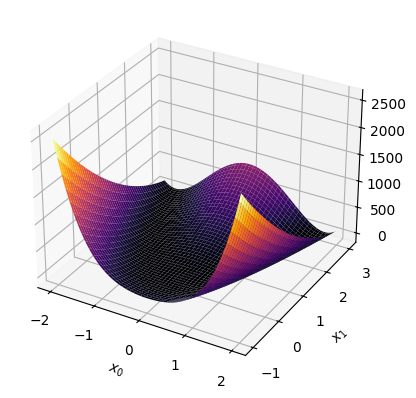

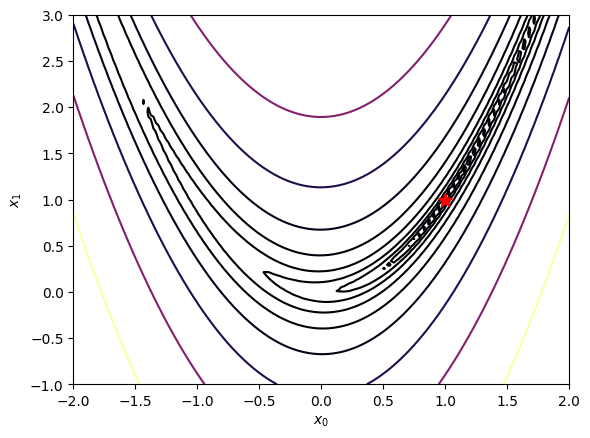

In [11]:
# plot rosenbrock function
import matplotlib.pyplot as plt
import numpy as np
# use latex for font rendering
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x0 = np.linspace(-2, 2, 100)
x1 = np.linspace(-1, 3, 100)
x0, x1 = np.meshgrid(x0, x1)
f = (1 - x0)**2 + 100*(x1 - x0**2)**2
# make jet colormap with stonger collor for lower values
ax.plot_surface(x0, x1, f, cmap='inferno')

# Highlight the minimum
min_point = np.array([1., 1.])
min_point_ = min_point.reshape(-1, 1)
f_min = (1 - min_point_[0])**2 + 100*(min_point_[1] - min_point_[0]**2)**2
ax.scatter(min_point_[0], min_point_[1], f_min, color='r', s=100) # s is the size of the point


plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.show()

plt.contour(x0, x1, f, levels=np.logspace(-1, 3, 10), cmap='inferno')
plt.plot(1, 1, 'r*', markersize=10)
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.show()

Twenty iterations are set for each optimization algorithm to find the global minimum. The starting point is initialised randomly for 100 different runs.

In [12]:
iterations = 20  # number of iterations to run the optimization
number_of_cases = 100  # number of cases to generate
N = 2  # number of dimensions
list_of_random_numbers =[[np.random.rand() for i in range(N)] for j in range(number_of_cases)]

In [13]:
%time
from functools import partial
import torch
from torch import optim

def rosenbrock(x, N):
    return sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))

result_torch = []
for j in range(number_of_cases):
    a = torch.tensor(list_of_random_numbers[j], requires_grad=True)
    function = partial(rosenbrock, a, N)
    optimizer = optim.LBFGS([a])
    for _ in range(iterations):
        def closure():
            optimizer.zero_grad()
            loss = function()
            loss.backward()
            return loss
        optimizer.step(closure)
    result_torch.append(a.tolist())

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


I will be exploring the `firedrake.adjoint` module, which combines Firedrake's automatic differentiation capabilities with SciPy's optimization algorithms. The automated adjoint is given by first tape the forward model as a list of blocks that store the operations. Then, the adjoint model is automatically generated by reversing the order of the blocks and applying the chain rule to each block. The adjoint model is then used to compute the gradient of the objective function with respect to the control variables.

In Firedrake, we are solving the forward problem using the rosenbrock function in weak form. We consider the Real function space $\mathbb{R}^{N}$ and the control variable $\mathbf{x} \in \mathbb{R}^{N}$.

We first import firedrake and firedrake.adjoint. We start to tape the forward model with ``continue_annotation()``.

In [14]:
from firedrake import *
from firedrake.adjoint import *
continue_annotation()

True

In [15]:
%time
mesh = UnitSquareMesh(1, 1)
R = FunctionSpace(mesh, "R", 0)
result_firedrake = []
for j in range(number_of_cases):
    x = [Function(R, val=list_of_random_numbers[j][i]) for i in range(N)]
    f = sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))
    # cost function
    J = assemble(f * dx(domain=mesh))
    c = [Control(xi) for xi in x]
    rf = ReducedFunctional(J, c)
    result = minimize(rf, method="L-BFGS-B", options={"maxiter": iterations})
    result_firedrake.append([float(result[i]) for i in range(len(result))])
    # Clear the tape.
    get_working_tape().clear_tape()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


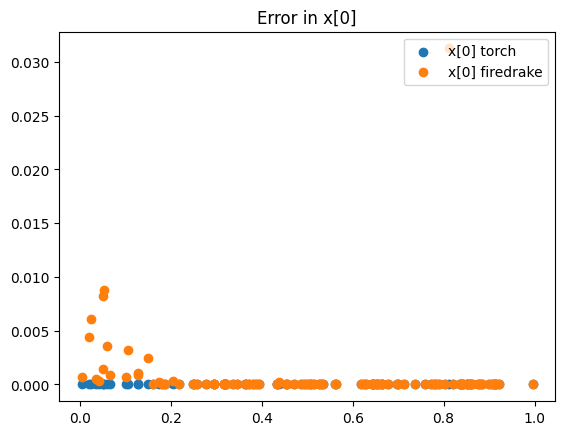

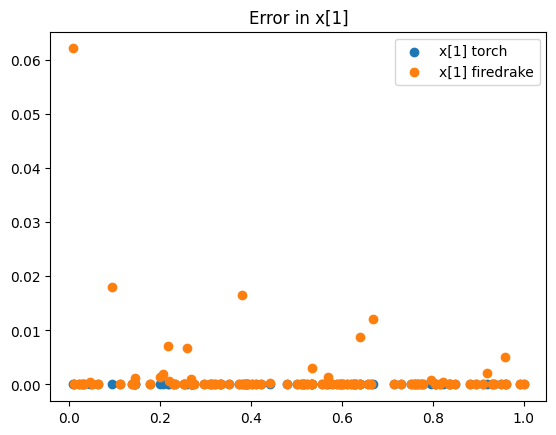

In [16]:
errors_torch = [
    [abs(result_torch[j][i] - 1.0) for i in range(len(result_torch[j]))] 
    for j in range(number_of_cases)
    ]
errors_firedrake = [
    [abs(result_firedrake[j][i] - 1.0) for i in range(len(result_firedrake[j]))]
    for j in range(number_of_cases)
    ]


for i in range(len(errors_torch[0])):
    plt.scatter(
        [list_of_random_numbers[j][i] for j in range(number_of_cases)],
        [errors_torch[j][i] for j in range(number_of_cases)], label=f'x[{i}] torch'
        )
    plt.scatter(
        [list_of_random_numbers[j][i] for j in range(number_of_cases)],
        [errors_firedrake[j][i] for j in range(number_of_cases)], label=f'x[{i}] firedrake'
        )
    plt.legend(loc='upper right')
    plt.title(f'Error in x[{i}]')
    plt.show()

In the above plot, we display the error in the solution for each of the two methods. The results appear very similar for both approaches. The differences in error can be attributed to the optimization algorithms used: Firedrake employs the L-BFGS-B algorithm from SciPy, whereas PyTorch utilizes its own LBFGS algorithm. Despite these differences, the automatic differentiation for gradient computation in both cases produces matching results, as shown in the final plot of the notebook.

In [17]:
%time
result_torch_grad = []
for j in range(number_of_cases):
    a = torch.tensor(list_of_random_numbers[j], requires_grad=True)
    function = partial(rosenbrock, a, N)
    loss = function()
    loss.backward()
    result_torch_grad.append(a.grad.tolist())

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 1.91 µs


In [18]:
%time
result_firedrake_grad = []
for j in range(number_of_cases):
    x = [Function(R, val=list_of_random_numbers[j][i]) for i in range(N)]
    f = sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))
    # cost function
    J = assemble(f * dx(domain=mesh))
    c = [Control(xi) for xi in x]
    rf = ReducedFunctional(J, c)
    grad = rf.derivative()
    result_firedrake_grad.append([float(grad[i]) for i in range(len(grad))])
    # Clear the tape.
    get_working_tape().clear_tape()

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


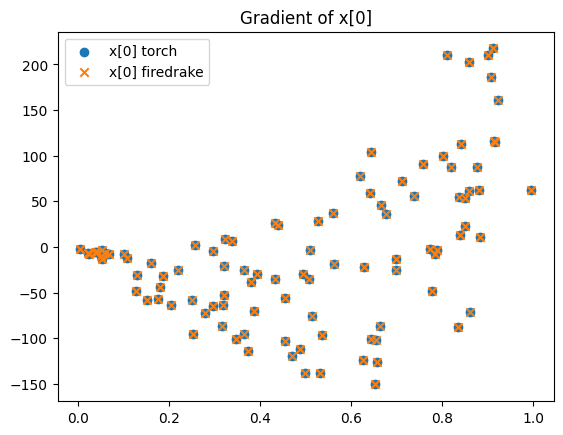

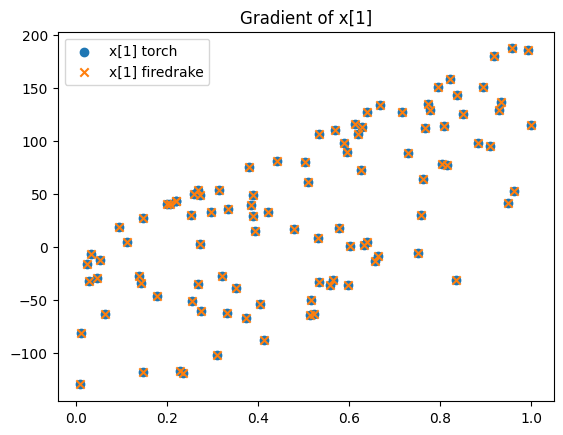

In [19]:
for i in range(len(result_torch_grad[0])):
    plt.scatter(
        [list_of_random_numbers[j][i] for j in range(number_of_cases)],
        [result_torch_grad[j][i] for j in range(number_of_cases)], label=f'x[{i}] torch', marker='o'
        )
    plt.scatter(
        [list_of_random_numbers[j][i] for j in range(number_of_cases)],
        [result_firedrake_grad[j][i] for j in range(number_of_cases)], label=f'x[{i}] firedrake', marker='x'
        )
    plt.legend(loc='best')
    plt.title(f'Gradient of x[{i}]')
    plt.show()

## Final considerations 

The Rosenbrock function is a classic non-convex optimization problem that performs as a benchmark for testing optimization algorithms. In this notebook, we explored two optimization libraries: PyTorch and Firedrake. Both libraries utilize automatic differentiation to compute the gradient of the objective function with respect to the control variables, resulting in similar outcomes. The differences in error can be attributed to the optimization algorithms used: Firedrake employs the L-BFGS-B algorithm from SciPy, whereas PyTorch utilizes its own LBFGS algorithm. The automatic differentiation for gradient computation in both cases produces matching results.